In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import os
from tensorflow.keras.layers import Conv2D,Conv1D, GlobalAveragePooling2D, Dense, Dropout, DepthwiseConv2D, DepthwiseConv1D

# Imports for visualizations
import shap as shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [4]:
# Specify the path to your model and the data directories and parameters


MODEL_DIR = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/models/2025_07_31_plant_classifier_fine_tuned__model.keras"
TRAIN_DIR = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/original_data/2.1.1 New Plant Diseases/train"
VALID_DIR = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/original_data/2.1.1 New Plant Diseases/valid"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [5]:
# Load training data from the 'train' directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    shuffle=True, 
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Load validation data from the 'valid' directory
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VALID_DIR,
    shuffle=False, 
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Get class names from the dataset object
class_names = train_dataset.class_names
num_classes = len(class_names)
print("Found classes:", class_names)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.
Found classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold'

In [6]:
# Load the pre-trained model
model = tf.keras.models.load_model(MODEL_DIR 
,custom_objects={'preprocess_input': preprocess_input})

# Display the model architecture
model.summary()  

# Check input shape compatibility
print(f"Model input shape: {model.input_shape}")
print(f"Number of classes: {num_classes}")  # Should be 38


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,126,900 (23.37 MB)

 Trainable params: 1,910,118 (7.29 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 3,820,238 (14.57 MB)

Model input shape: (None, 224, 224, 3)
Number of classes: 38


In [7]:
# Print all layers of the model used (MobileNetV2)
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} ({layer.__class__.__name__})")

mobilenet_layers = model.get_layer('mobilenetv2_1.00_224').layers
for i, layer in enumerate(mobilenet_layers):
    if 'Conv' in layer.__class__.__name__:
        print(f"{i}: {layer.name} ({layer.__class__.__name__})")

0: input_layer_15 (InputLayer)
1: sequential_2 (Sequential)
2: mobilenetv2_1.00_224 (Functional)
3: global_average_pooling2d_6 (GlobalAveragePooling2D)
4: dropout_6 (Dropout)
5: dense_6 (Dense)
1: Conv1 (Conv2D)
4: expanded_conv_depthwise (DepthwiseConv2D)
7: expanded_conv_project (Conv2D)
9: block_1_expand (Conv2D)
13: block_1_depthwise (DepthwiseConv2D)
16: block_1_project (Conv2D)
18: block_2_expand (Conv2D)
21: block_2_depthwise (DepthwiseConv2D)
24: block_2_project (Conv2D)
27: block_3_expand (Conv2D)
31: block_3_depthwise (DepthwiseConv2D)
34: block_3_project (Conv2D)
36: block_4_expand (Conv2D)
39: block_4_depthwise (DepthwiseConv2D)
42: block_4_project (Conv2D)
45: block_5_expand (Conv2D)
48: block_5_depthwise (DepthwiseConv2D)
51: block_5_project (Conv2D)
54: block_6_expand (Conv2D)
58: block_6_depthwise (DepthwiseConv2D)
61: block_6_project (Conv2D)
63: block_7_expand (Conv2D)
66: block_7_depthwise (DepthwiseConv2D)
69: block_7_project (Conv2D)
72: block_8_expand (Conv2D)
75:

In [36]:
from collections import defaultdict

# Ziel: Zwei Bilder pro Klasse (z. B. 'Apple___healthy', 'Tomato___Early_blight', …)
images_by_class = defaultdict(list)
total_classes = 38 # Hier die genaue Anzahl Ihrer Klassen einfügen

# Iteriere durch das gesamte Validierungsset
for image, label in validation_dataset.unbatch().as_numpy_iterator():
    label_int = int(label)
    # Check if we already have 2 images for this class
    if len(images_by_class[label_int]) < 2:
        images_by_class[label_int].append(image)
    
    # Abbruchbedingung: Wenn alle Klassen mindestens 2 Bilder haben
    if all(len(v) >= 2 for v in images_by_class.values()) and len(images_by_class) == total_classes:
        break

# Jetzt alle gesammelten Bilder & Labels extrahieren
all_images = []
all_labels = []

for label, imgs in images_by_class.items():
    all_images.extend(imgs)
    all_labels.extend([label] * len(imgs))

# In Arrays umwandeln
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Drucken Sie die Bestätigung aus
print(f"Es wurden {len(all_images)} Bilder von {len(images_by_class)} Klassen gesammelt.")

Es wurden 76 Bilder von 38 Klassen gesammelt.


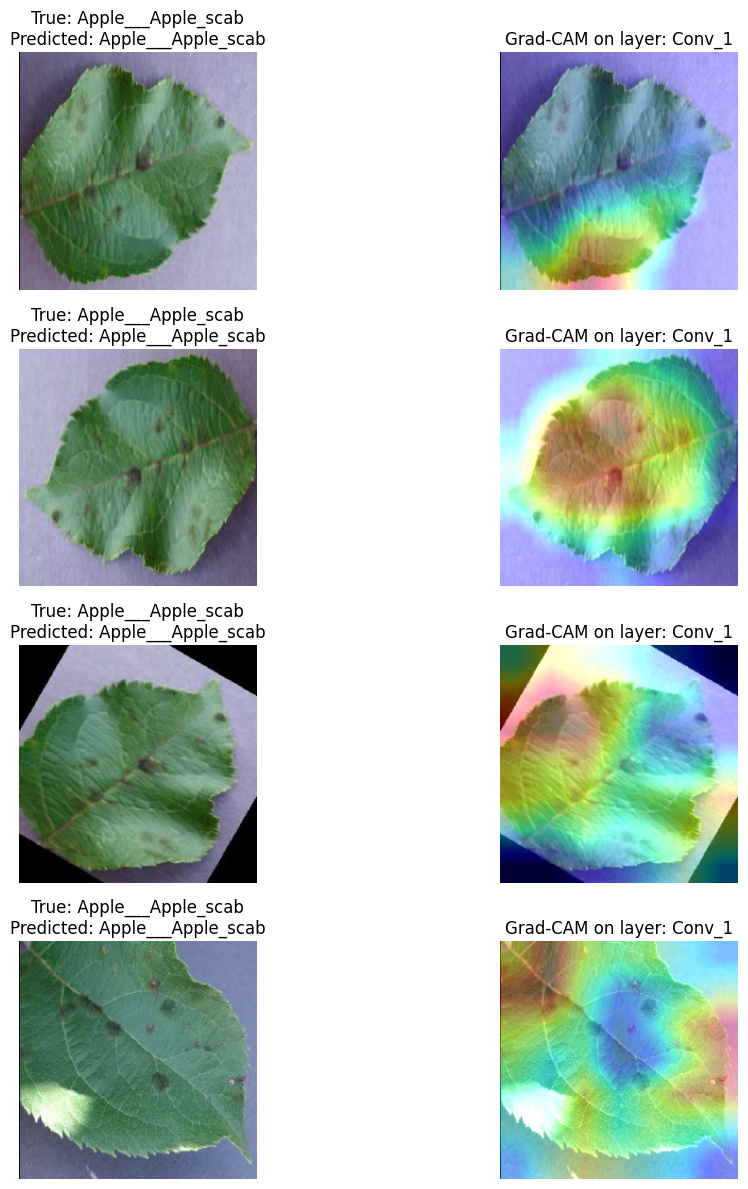

In [38]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


def grad_cam(img_array, model, target_conv_layer):
    """
    Computes Grad-CAM by manually reconstructing the model's graph path.
    """
    # 1. Manually preprocess the input image
    img_array_expanded = tf.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(tf.cast(img_array_expanded, dtype=tf.float32))

    # 2. Manually reconstruct the graph path from the base model's input
    base_model = model.get_layer('mobilenetv2_1.00_224')
    
    grad_model_for_outputs = tf.keras.models.Model(
        [base_model.inputs], [base_model.get_layer(target_conv_layer.name).output, base_model.output]
    )
    
    x = grad_model_for_outputs.output[1]
    x = model.get_layer('global_average_pooling2d_6')(x)
    x = model.get_layer('dropout_6')(x)
    final_preds = model.get_layer('dense_6')(x)

    final_model = tf.keras.Model(inputs=grad_model_for_outputs.inputs, outputs=[grad_model_for_outputs.output[0], final_preds])

    # 3. Compute gradients
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = final_model(preprocessed_img)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 4. Compute heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (img_array.shape[0], img_array.shape[1])).numpy()
    heatmap_squeezed = np.squeeze(heatmap_resized)
    heatmap_colored = plt.cm.jet(heatmap_squeezed)[..., :3]

    # 5. Superimpose heatmap on the original image
    superimposed_img = heatmap_colored * 0.4 + (img_array / 255.0)

    return np.clip(superimposed_img, 0, 1), pred_index.numpy()


# takes 'labels' and 'class_names' to create better titles.
def show_grad_cam(images, labels, model, class_names, target_layer_name):
    """
    Displays the original image with True/Predicted labels and its Grad-CAM overlay.
    """
    try:
        target_layer = model.get_layer('mobilenetv2_1.00_224').get_layer(target_layer_name)
    except ValueError as e:
        print(f"Error: Could not find layer '{target_layer_name}'.")
        return

    plt.figure(figsize=(12, 3 * len(images)))
    for i, img in enumerate(images):
        # Generate the Grad-CAM image and get the predicted class index
        grad_cam_image, predicted_class_index = grad_cam(img, model, target_layer)

        # Get the true and predicted class names for the title
        true_class_name = class_names[labels[i]]
        predicted_class_name = class_names[predicted_class_index]
        
        title_text = f"True: {true_class_name}\nPredicted: {predicted_class_name}"

        # Display Original Image
        ax = plt.subplot(len(images), 2, 2 * i + 1)
        plt.imshow(img.astype("uint8"))
        plt.title(title_text)
        plt.axis("off")

        # Display Grad-CAM Image
        ax = plt.subplot(len(images), 2, 2 * i + 2)
        plt.imshow(grad_cam_image)
        plt.title(f'Grad-CAM on layer: {target_layer_name}')
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# --- FINAL CALL ---

show_grad_cam(images, labels, model, class_names, 'Conv_1')

Es wurden 76 Bilder von 38 Klassen gesammelt.


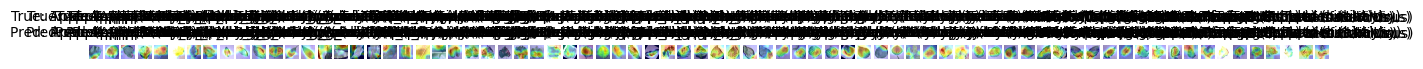

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import os
from PIL import Image
from collections import defaultdict
from tensorflow.keras.layers import Conv2D

# --- Die angepasste und korrigierte grad_cam Funktion ---
def grad_cam(img_array, model, target_conv_layer_name):
    """
    Computes Grad-CAM by manually reconstructing the model's graph path.
    """
    # 1. Manually preprocess the input image
    if len(img_array.shape) == 2:
        img_array = np.stack([img_array, img_array, img_array], axis=-1)
    if img_array.shape[-1] != 3:
        img_array = img_array[..., :3]

    img_array_expanded = tf.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(tf.cast(img_array_expanded, dtype=tf.float32))

    # 2. Manually reconstruct the graph path from the base model's input
    base_model = model.get_layer('mobilenetv2_1.00_224')
    
    # Get the target convolutional layer from the base model
    target_conv_layer = base_model.get_layer(target_conv_layer_name)

    grad_model_for_outputs = tf.keras.models.Model(
        [base_model.inputs], [target_conv_layer.output, base_model.output]
    )
    
    x = grad_model_for_outputs.output[1]
    
    # 🚨 Korrekte Schichtnamen aus der model.summary() verwenden
    x = model.get_layer('global_average_pooling2d_6')(x)
    x = model.get_layer('dropout_6')(x)
    final_preds = model.get_layer('dense_6')(x)
    
    final_model = tf.keras.Model(inputs=grad_model_for_outputs.inputs, outputs=[grad_model_for_outputs.output[0], final_preds])
    
    # 3. Compute gradients
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = final_model(preprocessed_img)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 4. Compute heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (img_array.shape[0], img_array.shape[1])).numpy()
    heatmap_squeezed = np.squeeze(heatmap_resized)
    heatmap_colored = plt.cm.jet(heatmap_squeezed)[..., :3]

    # 5. Superimpose heatmap on the original image
    superimposed_img = heatmap_colored * 0.4 + (img_array / 255.0)

    return np.clip(superimposed_img, 0, 1), pred_index.numpy()

# --- Ihre angepasste show_grad_cam_cnn Funktion ---
def format_class_name(label):
    if "___" in label:
        plant, disease = label.split("___")
        return f"{plant} ({disease.replace('_', ' ')})"
    else:
        return label

def show_grad_cam_cnn(images, labels, model, class_names, save_dir=None):
    os.makedirs(save_dir, exist_ok=True) if save_dir else None

    number_of_images = images.shape[0]
    
    # Hinzufügen des Zugriffs auf die MobileNet-Schichten
    mobilenet_base = model.get_layer('mobilenetv2_1.00_224')
    conv_layers = [layer.name for layer in mobilenet_base.layers if isinstance(layer, Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D)]
    conv_layers = conv_layers[-1:] # Letzte Schicht
    
    plt.figure(figsize=(16, 16))

    for j, layer in enumerate(conv_layers):
        for i in range(number_of_images):
            # Grad-CAM-Bild und vorhergesagte Klasse erhalten
            grad_cam_image, predicted_class_index = grad_cam(images[i], model, layer)
            true_label = format_class_name(class_names[labels[i]])
            predicted_label = format_class_name(class_names[predicted_class_index])
            
            subplot_index = i + 1 + j * number_of_images
            plt.subplot(len(conv_layers), number_of_images, subplot_index)
            plt.title(f'True: {true_label}\nPred: {predicted_label}', fontsize=10)
            plt.imshow(grad_cam_image)
            plt.axis("off")

            if save_dir:
        # Originalbild speichern
                filename_orig = f"{class_names[labels[i]]}_original_img{i+1}.png"
                filepath_orig = os.path.join(save_dir, filename_orig)
                # 🚨 Hier die Umwandlung hinzufügen
                Image.fromarray(images[i].astype(np.uint8)).save(filepath_orig)
                
                # Grad-CAM-Bild speichern
                filename_gradcam = f"{class_names[labels[i]]}_grad_cam_img{i+1}.png"
                filepath_gradcam = os.path.join(save_dir, filename_gradcam)
                gradcam_uint8 = (grad_cam_image * 255).astype(np.uint8)
                Image.fromarray(gradcam_uint8).save(filepath_gradcam)

    if not save_dir:
        plt.show()

# --- Bildauswahl-Logik (aus Ihrem ursprünglichen Code) ---
from collections import defaultdict

# Ziel: Zwei Bilder pro Klasse (z. B. 'Apple___healthy', 'Tomato___Early_blight', …)
images_by_class = defaultdict(list)
total_classes = 38 # Hier die genaue Anzahl Ihrer Klassen einfügen

# Iteriere durch das gesamte Validierungsset
for image, label in validation_dataset.unbatch().as_numpy_iterator():
    label_int = int(label)
    # Check if we already have 2 images for this class
    if len(images_by_class[label_int]) < 2:
        images_by_class[label_int].append(image)
    
    # Abbruchbedingung: Wenn alle Klassen mindestens 2 Bilder haben
    if all(len(v) >= 2 for v in images_by_class.values()) and len(images_by_class) == total_classes:
        break

# Jetzt alle gesammelten Bilder & Labels extrahieren
all_images = []
all_labels = []

for label, imgs in images_by_class.items():
    all_images.extend(imgs)
    all_labels.extend([label] * len(imgs))

# In Arrays umwandeln
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Print
print(f"Es wurden {len(all_images)} Bilder von {len(images_by_class)} Klassen gesammelt.")

# --- Final Call ---
save_path = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_grad_cam/advanced_model"
show_grad_cam_cnn(all_images, all_labels, model, class_names, save_dir=save_path)